# Dog Breed Image Classification Model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import pathlib
import pandas as pd

tf.get_logger().setLevel('ERROR')

In [2]:
# making sure that tensorflow is going to be using GPU for calculations
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading

In [3]:
# set up connection to folder
data_dir = "../Dog_Breed_Files/Images/"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20580


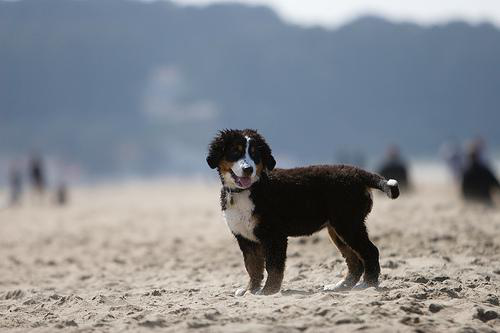

In [5]:
# confirm connection by checking out a bernese mountain dog
dog = list(data_dir.glob('n02107683-Bernese_mountain_dog/*'))
PIL.Image.open(str(dog[51]))

## Set up Data

While we're aware of the "image_dataset_from_directory()" keras utility, we're going to set up a custom image preprocessing pipeline for maximum flexibility with tuning model parameters and for deploying the model later.

We will want all of the images to be the same size and for processing to work in batches.

In [6]:
# define parameters to be used in loading and modeling
batch_size = 32
img_height = 224
img_width = 224

In [7]:
# set up a list that contains every photo in the directory
image_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
image_list = image_list.shuffle(image_count, reshuffle_each_iteration=False)

### Building Class Labels

In [8]:
# investigate the file path for the photos
for image in image_list.take(3):
    print(image.numpy())

b'..\\Dog_Breed_Files\\Images\\n02093428-American_Staffordshire_terrier\\n02093428_3269.jpg'
b'..\\Dog_Breed_Files\\Images\\n02107908-Appenzeller\\n02107908_3387.jpg'
b'..\\Dog_Breed_Files\\Images\\n02096585-Boston_bull\\n02096585_1586.jpg'


In [9]:
# note the folder names have a lot of extra info in them. when we get an answer at the end we'll use a dataframe to grab the cleaned name from the messy folder name
class_names = []

for folder_name in os.listdir("../Dog_Breed_Files/Images/"):
    class_names.append(folder_name)

### Set up Train/Test Split

Going to use an 80/20 train test split here. (can revisit later)

In [10]:
test_size = int(image_count*0.2)
train_data = image_list.skip(test_size)
test_data = image_list.take(test_size)

In [11]:
# check size of our training and testing data (expecting sum to be 20,580)
print(tf.data.experimental.cardinality(train_data).numpy())
print(tf.data.experimental.cardinality(test_data).numpy())
print(tf.data.experimental.cardinality(train_data).numpy() + tf.data.experimental.cardinality(test_data).numpy())

16464
4116
20580


### Functions for loading and preprocessing

In [12]:
# this will look at the file path and assign it a number [0-119] based on which dog breed it is (number is relative to where it lies in the folder structure)
def get_label(file_path):
    # take the path and separate it into components by the /
    parts = tf.strings.split(file_path, os.path.sep)
    
    # looking at the file structure above, the 2nd to last element is the class directory
    one_hot = parts[-2] == class_names

    # integer encode the label
    label = tf.argmax(one_hot)
    return label

In [13]:
# this will look at the image in a file path, turn it into an RGB array, then resize it to our desired size
def decode_image(img):
    img = tf.io.read_file(img)

    # parse the image as a uint8 tensor, 3 channels for RGB color
    img = tf.image.decode_jpeg(img, channels=3)

    # convert color channels from [0-255] to [0-1]. done here as opposed to in a model layer for increased efficiency
    img = tf.image.convert_image_dtype(img, tf.float32)

    # resize the image to  standardized size
    img = tf.image.resize(img, [img_height, img_width])
    return img

In [14]:
# this will combine the two functions above to get a label and an encoded tensor for each image it looks at
def processing(file_path):
    # get the folder name
    label = get_label(file_path)
    
    # load image, decode image
    img = decode_image(file_path)
    return img, label

In [15]:
# map the processing pipeline to each data set. 
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.map(processing)
test_data = test_data.map(processing)

In [16]:
# expecting each image to be (224, 224, 3) shape
for image, label in train_data.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  18
Image shape:  (224, 224, 3)
Label:  78
Image shape:  (224, 224, 3)
Label:  103


### Set up performance features

In [17]:
def performance_enhance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [18]:
train_data = performance_enhance(train_data)
test_data = performance_enhance(test_data)
num_classes = len(class_names)

### Visualize what we have

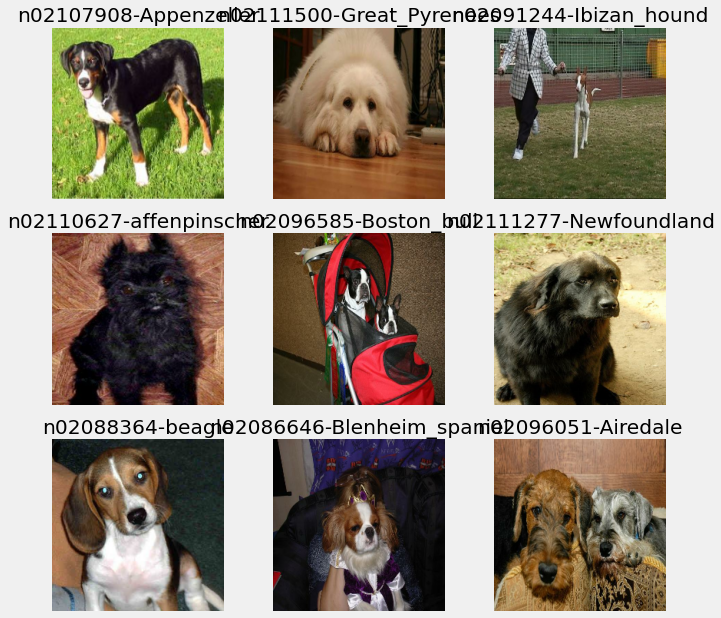

In [127]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Basic Hand-made Model

We know from researching that Convolutional Neural Networks (CNN Models) are often used to classify images. We'll run our image through multiple layers of convolution and pooling and then use "flatten" to turn that array into a vector that can be read by the dense layers that follow.

We'll use the Adam optimizer. And since this is a multi-cateogry categorization problem we'll use the Sparse Categorical Crossentropy loss function.

In [135]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [136]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [137]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)     

In [138]:
epochs = 30
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

Epoch 1/30
515/515 [==============================] - 13s 25ms/step - loss: 4.7709 - accuracy: 0.0136 - val_loss: 4.6588 - val_accuracy: 0.0190
Epoch 2/30
515/515 [==============================] - 13s 24ms/step - loss: 4.5995 - accuracy: 0.0230 - val_loss: 4.5646 - val_accuracy: 0.0243
Epoch 3/30
515/515 [==============================] - 13s 24ms/step - loss: 4.4494 - accuracy: 0.0385 - val_loss: 4.3638 - val_accuracy: 0.0469
Epoch 4/30
515/515 [==============================] - 12s 24ms/step - loss: 4.1724 - accuracy: 0.0675 - val_loss: 4.3138 - val_accuracy: 0.0593
Epoch 5/30
515/515 [==============================] - 13s 24ms/step - loss: 3.8830 - accuracy: 0.1090 - val_loss: 4.3894 - val_accuracy: 0.0632
Epoch 6/30
515/515 [==============================] - 13s 24ms/step - loss: 3.5310 - accuracy: 0.1591 - val_loss: 4.5882 - val_accuracy: 0.0646
Epoch 7/30
515/515 [==============================] - 12s 24ms/step - loss: 3.0721 - accuracy: 0.2406 - val_loss: 4.9842 - val_accuracy:

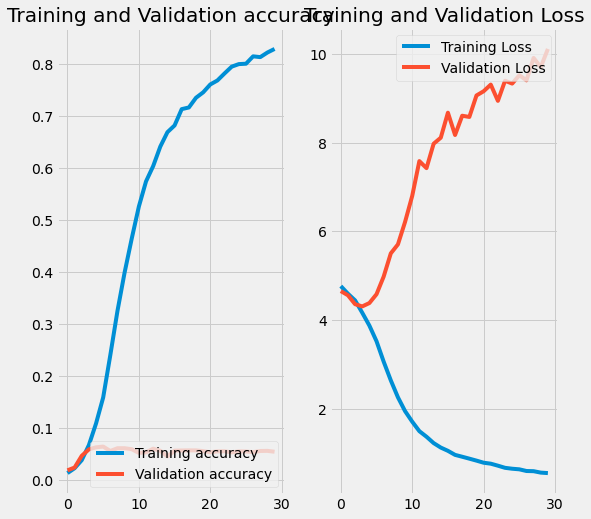

In [139]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model is very bad! We'll try data augmentation but we may end up needing a transfer learning model that's already seen millions of images to learn general shapes as opposed to building one from scratch.

## Hand-made Model with Data Augmentation

Since there are only 200ish photos for each dog breed this model is a good candidate for data augmentation, where we randomly scale, rotate, and translate the photos in order to make each photo give more information to the model.

In [140]:
# data augmentation here
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

In [142]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [143]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [144]:
epochs = 30
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

Epoch 1/30
515/515 [==============================] - 110s 208ms/step - loss: 4.7428 - accuracy: 0.0147 - val_loss: 4.6411 - val_accuracy: 0.0219
Epoch 2/30
515/515 [==============================] - 107s 208ms/step - loss: 4.5827 - accuracy: 0.0220 - val_loss: 4.5224 - val_accuracy: 0.0299
Epoch 3/30
515/515 [==============================] - 108s 209ms/step - loss: 4.4608 - accuracy: 0.0298 - val_loss: 4.3827 - val_accuracy: 0.0476
Epoch 4/30
515/515 [==============================] - 108s 209ms/step - loss: 4.3774 - accuracy: 0.0406 - val_loss: 4.3144 - val_accuracy: 0.0476
Epoch 5/30
515/515 [==============================] - 108s 209ms/step - loss: 4.3062 - accuracy: 0.0463 - val_loss: 4.2506 - val_accuracy: 0.0571
Epoch 6/30
515/515 [==============================] - 108s 209ms/step - loss: 4.2534 - accuracy: 0.0491 - val_loss: 4.1961 - val_accuracy: 0.0605
Epoch 7/30
515/515 [==============================] - 107s 208ms/step - loss: 4.2201 - accuracy: 0.0558 - val_loss: 4.1578 -

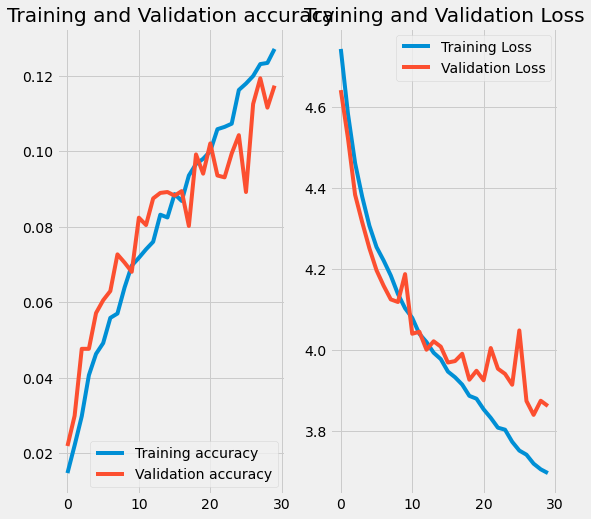

In [145]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Better! This model still has the accuracy increasing after 30 epochs so it might get us to a reasonable model eventually if we let it run overnight, but it's worth looking into transfer learning models to see how long those might take before making that commitment.

## Transfer Learning Models

We're going to use a function to compare five different image classification models found on TF Hub. For each one we'll compare a basic model feeding directly into the output layer as a baseline. Then a model with some added dense layers layers to see if that increases learning. And then finally a pass with data augmentation to see how that effects the outcome. We'll compare the effects of the extra layers and data augmentation to see which we'll need, if any.

In [45]:
mobilenet_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"
resnet = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

models = {
    "mobilenet_v2" : mobilenet_v2,
    "mobilenet_v3" : mobilenet_v3,
    "inception_v3" : inception_v3,
    "efficientnet_v2" : efficientnet_v2,
    "resnet" : resnet
}

In [146]:
def model_testing(model, epoch, training, testing, model_type = 0):
    ''' Function for testing several transfer learning models at once.\n
        Model type 0 will be a basic model with no augmentation or extra layers.\n
        1 will be a model with extra dense layers.\n
        2 will be a model with augmentation.\n
        3 will be a model with extra layers and augmentation.\n
        '''

    base_model = hub.KerasLayer(
        model,
        input_shape=(img_height, img_width, 3),
        trainable=False)
    
    #simple model with no added layers trying to mess with things
    if model_type == 0:
            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])
    # some added dense and dropout layers to see if that improves learning
    elif model_type == 1:   
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Dense(250, activation='relu'),
            tf.keras.layers.Dropout(.30),
            tf.keras.layers.Dense(180, activation='relu'),
            tf.keras.layers.Dropout(.20),
            tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])
    # added augmentation
    elif model_type == 2:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
            tf.keras.layers.RandomRotation(0.15),
            tf.keras.layers.RandomZoom(0.2),
        ])
        model = tf.keras.Sequential([
            data_augmentation,
            base_model,
            tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])
    # added layers and augmentation
    elif model_type == 3:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
            tf.keras.layers.RandomRotation(0.15),
            tf.keras.layers.RandomZoom(0.2),
        ])     
        model = tf.keras.Sequential([
            data_augmentation,
            base_model,
            tf.keras.layers.Dense(250, activation='relu'),
            tf.keras.layers.Dropout(.30),
            tf.keras.layers.Dense(180, activation='relu'),
            tf.keras.layers.Dropout(.20),
            tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])   
    # error
    else:
        return print("Check documentation for what model type you want to run.")
    
    model.build((img_height, img_width, 3))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    
    history = model.fit(
        training,
        validation_data=testing,
        epochs=epoch,
        callbacks=[early_stopping]
        )
    
    return history

In [69]:
def visualize_metrics(metrics_dict, file_name):
    ''' A function to visualize all metrics from a created metrics dictionary created useing "model_testing" '''
    num_rows = len(metrics_dict.keys())

    fig, axes = plt.subplots(nrows=num_rows, 
                            ncols=2, 
                            figsize=(15, 25))

    fig.tight_layout(pad=5)

    plt.style.use('fivethirtyeight')

    i = 0
    j = 0
    for model, metrics in metrics_dict.items():
        axes[i][j].plot(metrics['accuracy'])
        axes[i][j].plot(metrics['val_accuracy'])
        axes[i][j].set_ylabel("Accuracy")
        axes[i][j].set_ylim((0, 1))
        axes[i][j].set_xlabel("Epochs")
        axes[i][j].set_title(f'Model {i + 1}: {model} Accuracy')
        axes[i][j].legend(['Train', 'Test'], loc='lower left')
        j += 1
        axes[i][j].plot(metrics['loss'])
        axes[i][j].plot(metrics['val_loss'])
        axes[i][j].set_ylabel("Loss")
        axes[i][j].set_ylim((0, 2))
        axes[i][j].set_xlabel("Epochs")
        axes[i][j].set_title(f'Model {i + 1}: {model} Loss')
        axes[i][j].legend(['Train', 'Test'], loc='upper left')
        i += 1
        j = 0
    
    plt.savefig(file_name)

### Basic Model

Testing each of the transfer models with no added layers or augmentation to see how they do.

In [61]:
# first testing on non-augmented data
model_metrics_base = {}
epochs = 50

for key, value in models.items():
    history = model_testing(value, epochs, train_data, test_data, model_type = 0)

    model_metrics_base[key] = {
        'accuracy' : history.history['accuracy'],
        'loss' : history.history['loss'],
        'val_accuracy' : history.history['val_accuracy'],
        'val_loss' : history.history['val_loss']
    }

Epoch 1/50
515/515 [==============================] - 23s 39ms/step - loss: 1.0550 - accuracy: 0.7230 - val_loss: 0.6478 - val_accuracy: 0.7993
Epoch 2/50
515/515 [==============================] - 20s 38ms/step - loss: 0.3814 - accuracy: 0.8800 - val_loss: 0.6229 - val_accuracy: 0.8127
Epoch 3/50
515/515 [==============================] - 20s 38ms/step - loss: 0.2439 - accuracy: 0.9262 - val_loss: 0.6547 - val_accuracy: 0.8083
Epoch 4/50
515/515 [==============================] - 20s 38ms/step - loss: 0.1668 - accuracy: 0.9533 - val_loss: 0.6840 - val_accuracy: 0.8000
Epoch 5/50
515/515 [==============================] - 20s 38ms/step - loss: 0.1218 - accuracy: 0.9693 - val_loss: 0.7068 - val_accuracy: 0.8078
Epoch 6/50
515/515 [==============================] - 20s 38ms/step - loss: 0.0934 - accuracy: 0.9778 - val_loss: 0.7327 - val_accuracy: 0.8076
Epoch 7/50
515/515 [==============================] - 20s 38ms/step - loss: 0.0743 - accuracy: 0.9838 - val_loss: 0.7511 - val_accuracy:

In [62]:
model_metrics_base_df = pd.DataFrame(model_metrics_base)
model_metrics_base_df.to_csv("testing_histories/basic_model.csv")

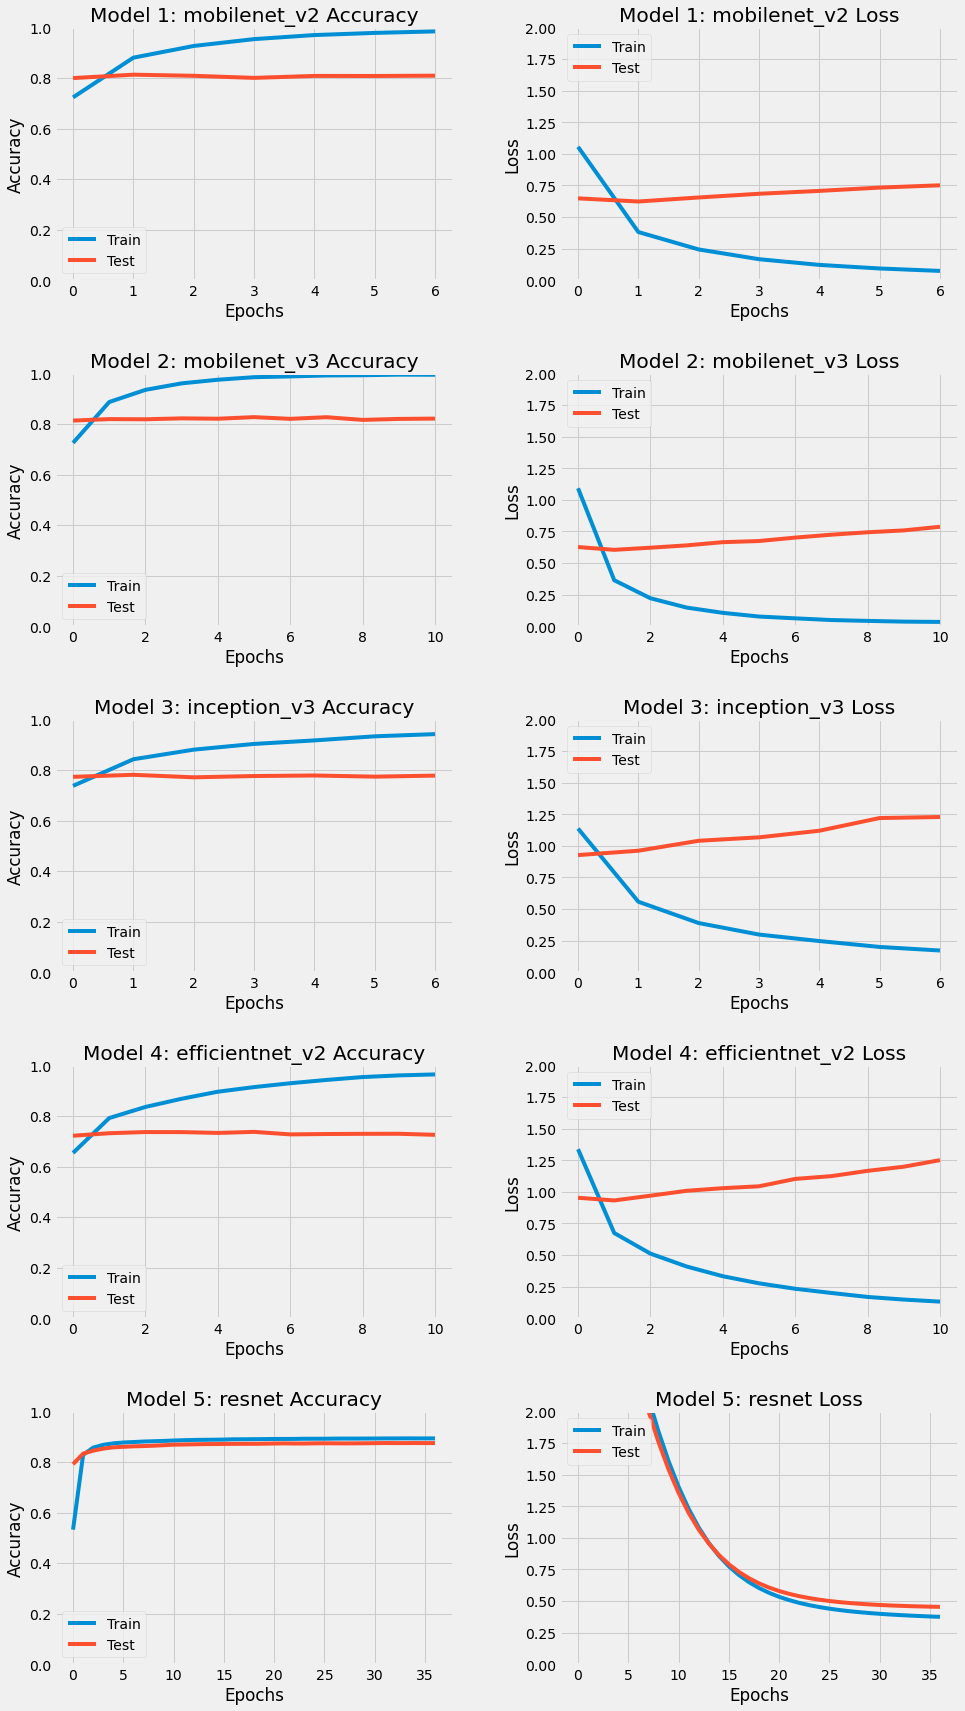

In [70]:
visualize_metrics(model_metrics_base, file_name='images/basic_model.png')

Initial look at the accuracy and loss graphs seems to show that the resnet model is a good candidate to consider going forward. Its train and test accuracies stayed near each other, and there was actually an increase in the accuracy after a few epochs, as opposed to starting around 80% and staying flat like most of the other models. And it clearly learned enough to lower the loss function. If resnet doesn't work out in future tests we could also consider mobilenetv3 since it had the highest accuracy of all the "flat" models, though it's not great to see the loss increasing as epochs go on.

### Add Layers

Now we'll try each of these models with two additional rounds of Dense layers to see if that has a noticeable effect on the learning. We'll also add a "dropout" layer in between each dense layer to help deal with overfitting.

In [72]:
model_metrics_layers = {}
epochs = 50

for key, value in models.items():
    history = model_testing(value, epochs, train_data, test_data, model_type = 1)

    model_metrics_layers[key] = {
        'accuracy' : history.history['accuracy'],
        'loss' : history.history['loss'],
        'val_accuracy' : history.history['val_accuracy'],
        'val_loss' : history.history['val_loss']
    }

Epoch 1/50
515/515 [==============================] - 25s 41ms/step - loss: 1.6507 - accuracy: 0.5727 - val_loss: 0.7162 - val_accuracy: 0.7775
Epoch 2/50
515/515 [==============================] - 20s 39ms/step - loss: 0.8192 - accuracy: 0.7530 - val_loss: 0.7094 - val_accuracy: 0.7891
Epoch 3/50
515/515 [==============================] - 20s 39ms/step - loss: 0.6635 - accuracy: 0.7948 - val_loss: 0.7056 - val_accuracy: 0.7937
Epoch 4/50
515/515 [==============================] - 20s 39ms/step - loss: 0.5762 - accuracy: 0.8172 - val_loss: 0.6871 - val_accuracy: 0.7981
Epoch 5/50
515/515 [==============================] - 20s 39ms/step - loss: 0.5045 - accuracy: 0.8385 - val_loss: 0.7010 - val_accuracy: 0.7991
Epoch 6/50
515/515 [==============================] - 20s 39ms/step - loss: 0.4663 - accuracy: 0.8503 - val_loss: 0.7152 - val_accuracy: 0.7998
Epoch 7/50
515/515 [==============================] - 20s 39ms/step - loss: 0.4239 - accuracy: 0.8593 - val_loss: 0.7398 - val_accuracy:

In [73]:
model_metrics_layers_df = pd.DataFrame(model_metrics_layers)
model_metrics_layers_df.to_csv("testing_histories/extra_layers.csv")

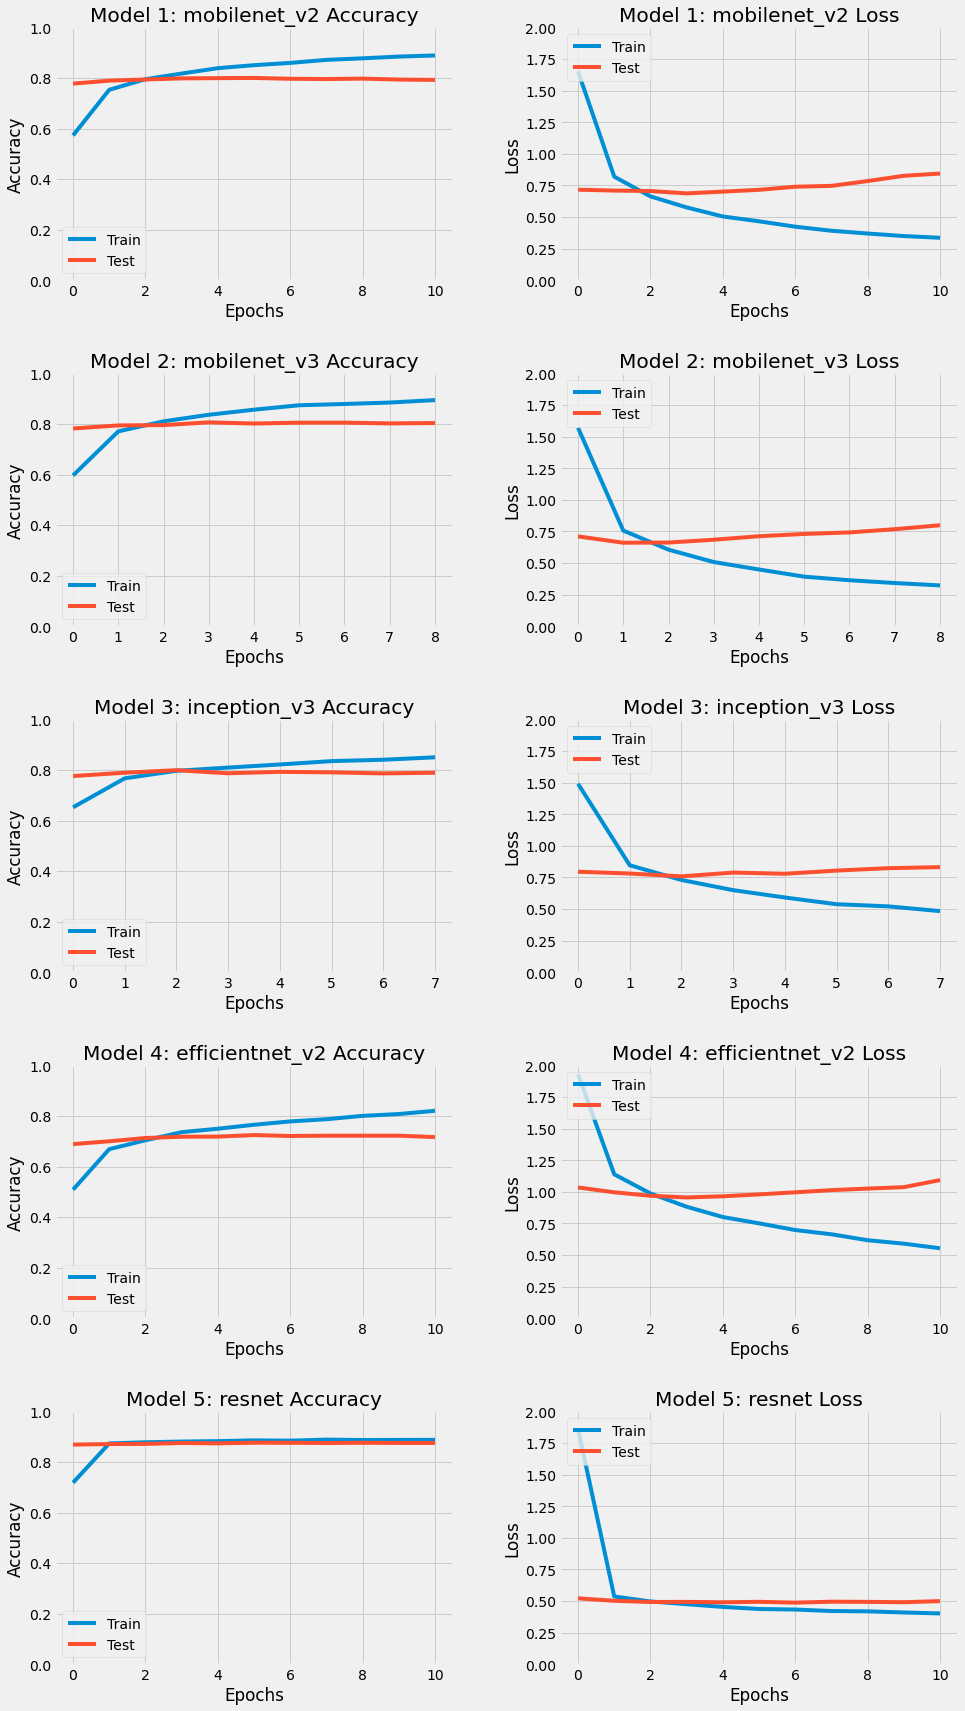

In [74]:
visualize_metrics(model_metrics_layers, file_name='images/extra_layers.png')

Here it looks like resnet is our winner again. It seems like the only difference that adding these extra layers made was that we started near the accuracy and loss we built to in the "basic" case and ended up in nearly the same place. But each model was able to finish in around 10 epochs vs the longer training time needed in the base model, so this one is worth considering as well. It takes extra computation time per epoch since we added in those dense layers, but doing far fewer epochs seems to have still decreased runtime by the end.

At this point it feels like we're going to be happy with the resnet model, but we're still going to go ahead and run all five through the augmentation process just to be absolutely sure.

### Add Augmentation

Now we'll try each of these models with data augmentation to see if that has a noticeable effect on the learning. After that we should have enough data to pick which transfer learning model we're going to adopt, and what extra manipulation we're going to do, if any.

In [76]:
model_metrics_augmentation = {}
epochs = 50

for key, value in models.items():
    history = model_testing(value, epochs, train_data, test_data, model_type = 2)

    model_metrics_augmentation[key] = {
        'accuracy' : history.history['accuracy'],
        'loss' : history.history['loss'],
        'val_accuracy' : history.history['val_accuracy'],
        'val_loss' : history.history['val_loss']
    }

Epoch 1/50
515/515 [==============================] - 121s 222ms/step - loss: 1.7320 - accuracy: 0.5618 - val_loss: 0.6869 - val_accuracy: 0.7894
Epoch 2/50
515/515 [==============================] - 113s 220ms/step - loss: 1.0105 - accuracy: 0.7137 - val_loss: 0.6505 - val_accuracy: 0.8022
Epoch 3/50
515/515 [==============================] - 112s 218ms/step - loss: 0.8977 - accuracy: 0.7376 - val_loss: 0.6541 - val_accuracy: 0.8039
Epoch 4/50
515/515 [==============================] - 113s 219ms/step - loss: 0.8400 - accuracy: 0.7546 - val_loss: 0.6766 - val_accuracy: 0.8010
Epoch 5/50
515/515 [==============================] - 113s 219ms/step - loss: 0.7770 - accuracy: 0.7690 - val_loss: 0.6838 - val_accuracy: 0.8003
Epoch 6/50
515/515 [==============================] - 113s 220ms/step - loss: 0.7618 - accuracy: 0.7755 - val_loss: 0.6959 - val_accuracy: 0.8017
Epoch 7/50
515/515 [==============================] - 113s 220ms/step - loss: 0.7187 - accuracy: 0.7819 - val_loss: 0.7264 -

In [78]:
model_metrics_augmentation_df = pd.DataFrame(model_metrics_augmentation)
model_metrics_augmentation_df.to_csv("testing_histories/with_augmentation.csv")

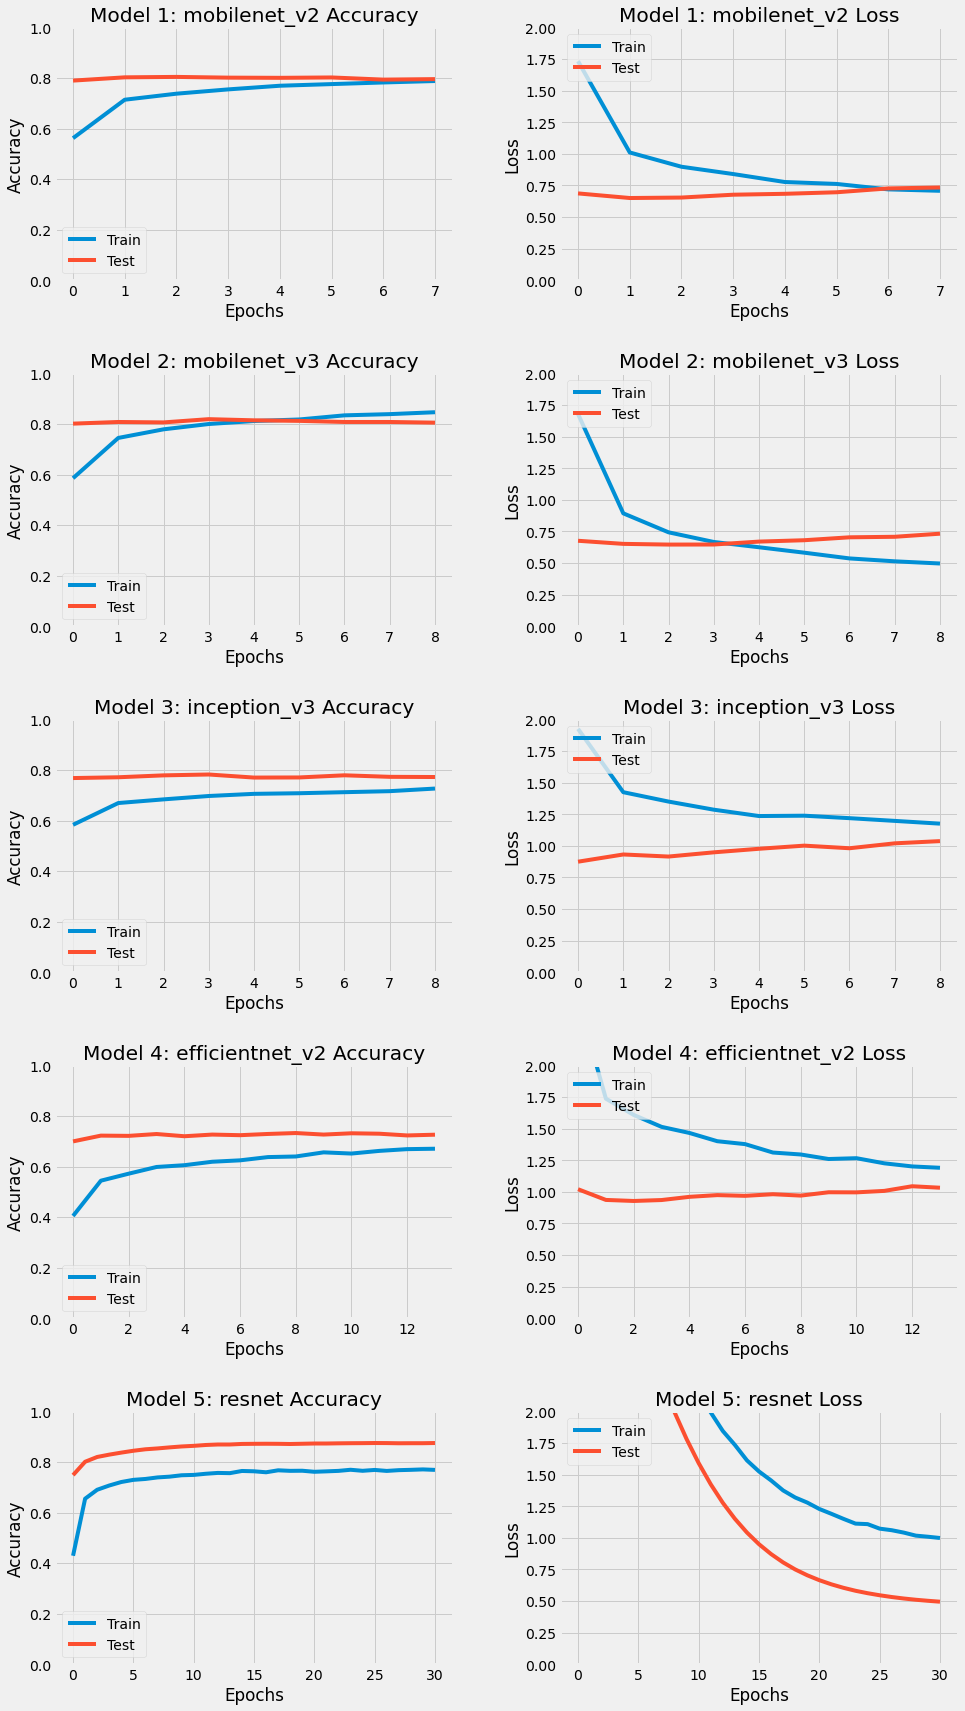

In [79]:
visualize_metrics(model_metrics_augmentation, file_name='images/with_augmentation.png')

Again, resnet gives us an actual increase in accuracy with training, the highest accuracy, and a decreasing loss function. Resnet is going to be the basis of our model going forward.

### Add Layers and Augmentation

At this point we know we're going to go with the resnet model, so let's just finish this out and see what it looks like if we put both the extra layers and the augmentation into our model.

In [82]:
resnet_history = model_testing(models['resnet'], 50, train_data, test_data, model_type = 3)

Epoch 1/50
515/515 [==============================] - 133s 241ms/step - loss: 2.4956 - accuracy: 0.5595 - val_loss: 0.5181 - val_accuracy: 0.8656
Epoch 2/50
515/515 [==============================] - 122s 237ms/step - loss: 1.1589 - accuracy: 0.7294 - val_loss: 0.4973 - val_accuracy: 0.8741
Epoch 3/50
515/515 [==============================] - 122s 238ms/step - loss: 1.0856 - accuracy: 0.7423 - val_loss: 0.4905 - val_accuracy: 0.8746
Epoch 4/50
515/515 [==============================] - 123s 238ms/step - loss: 1.0542 - accuracy: 0.7482 - val_loss: 0.4920 - val_accuracy: 0.8717
Epoch 5/50
515/515 [==============================] - 123s 238ms/step - loss: 1.0207 - accuracy: 0.7505 - val_loss: 0.4843 - val_accuracy: 0.8724
Epoch 6/50
515/515 [==============================] - 123s 238ms/step - loss: 1.0104 - accuracy: 0.7491 - val_loss: 0.4888 - val_accuracy: 0.8710
Epoch 7/50
515/515 [==============================] - 123s 238ms/step - loss: 0.9903 - accuracy: 0.7497 - val_loss: 0.4847 -

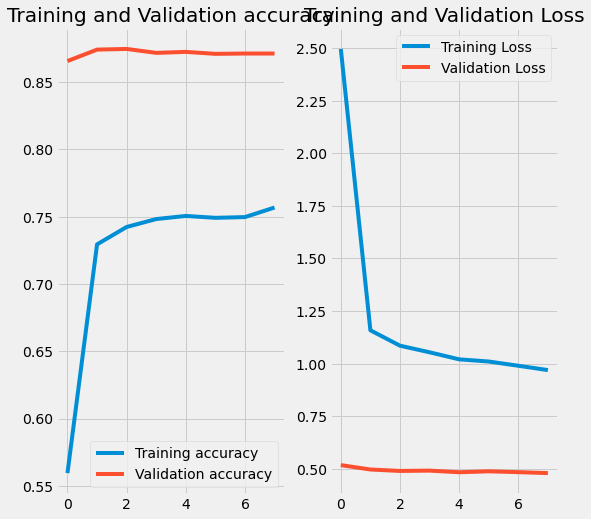

In [87]:
accuracy = resnet_history.history['accuracy']
val_accuracy = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('fivethirtyeight')
plt.savefig('images/layers_and_augmentation.png')
plt.show()


In [90]:
single_model_dict = {
    'resnet' : {
        'accuracy' : resnet_history.history['accuracy'],
        'loss' : resnet_history.history['loss'],
        'val_accuracy' : resnet_history.history['val_accuracy'],
        'val_loss' : resnet_history.history['val_loss']
    }
}

In [94]:
pd.DataFrame(single_model_dict).to_csv('testing_histories/layers_and_augmentation.csv')

## Conclusions

We know we'll be picking the resnet model, but we'll see if we can get any insight into which variant we should pick.

In [147]:
resnet_models = {
    "base_model" : model_metrics_base['resnet'],
    "add_layers" : model_metrics_layers['resnet'],
    "add_augmentation" : model_metrics_augmentation['resnet'],
    "layers_and_augmentation" : resnet_history.history}

In [125]:
for model, metrics in resnet_models.items():
    print(f"{model}:")
    print(f"   Num Epochs: {len(metrics['val_accuracy'])}")
    print(f"   Ending Validation Accuracy: {metrics['val_accuracy'][-1]: 0.4f}")
    print(f"   Ending Learning Accuracy: {metrics['accuracy'][-1]: 0.4f} ")
    print(f"   Max Validation Accuracy: {max(metrics['val_accuracy']): 0.4f}")
    print(f"   Ending Validation Loss: {metrics['val_loss'][-1]: 0.4f}")
    print(f"   Ending Learning Loss: {min(metrics['loss']):0.4f}\n")

base_model:
   Num Epochs: 37
   Ending Validation Accuracy:  0.8744
   Ending Learning Accuracy:  0.8930 
   Max Validation Accuracy:  0.8746
   Ending Validation Loss:  0.4540
   Ending Learning Loss: 0.3752

add_layers:
   Num Epochs: 11
   Ending Validation Accuracy:  0.8749
   Ending Learning Accuracy:  0.8871 
   Max Validation Accuracy:  0.8759
   Ending Validation Loss:  0.4994
   Ending Learning Loss: 0.4022

add_augmentation:
   Num Epochs: 31
   Ending Validation Accuracy:  0.8746
   Ending Learning Accuracy:  0.7684 
   Max Validation Accuracy:  0.8746
   Ending Validation Loss:  0.4949
   Ending Learning Loss: 0.9984

layers_and_augmentation:
   Num Epochs: 8
   Ending Validation Accuracy:  0.8712
   Ending Learning Accuracy:  0.7568 
   Max Validation Accuracy:  0.8746
   Ending Validation Loss:  0.4802
   Ending Learning Loss: 0.9696



The model summaries above show that each of the models we tested performed similarly, with the biggest difference being the number of epochs it took to get them to their ending accuracies. Our group has decided to use the “add_layers” model which doesn’t use any data augmentation, but does add a couple of dense layers after the transfer learning output but before the final prediction. The model we have chosen was able to achieve a validation accuracy above our required limit of 80%, while keeping the learning and validation accuracies approximate to each other. This model also avoided the overfitting situation where the learning data got very accurate but the testing data stayed the same, and the opposite, where the validation accuracy was high but learning couldn’t quite reach the desired accuracy. We were mainly focused on getting the validation accuracy as high as possible, but were pleased to see that our model was able to keep the losses fairly low as well.

With that model picked out we'll call the "exploration" phase done and build the final model in a new notebook with less clutter: [ml_model_final.ipynb]('ml_model_final.ipynb')
